---
title: "Excited State Methods"
author: "Elisabeth Welizky"
image: "main_image.png"
date: "2024-10-15"
categories: [mra, code]
format:
    html:
        code-fold: true
        eval: true
        freeze: false
    pdf:
        keep-tex: true
        cite-method: biblatex
        
        include-in-header:
            - text: |
                \usepackage{physics}
                \usepackage{physics}
code-annotations: hover
jupyter: blogqa
---


# Introduction and Ansatz
In this work we discuss an Eigensolver, which aims to find the ground state of a given Electronic Hamiltonian.
To briefly recap: A Hamiltonian itself describes the possible energies of a physical system, including both the kinetic and potential energy of that system and is represented by a matrix.
If we know the Hamiltonian, we can gain information about the physical states of the system. In the covered example, the Hamiltonian takes the following form

$$ 1.5  - 0.5 \cdot (Z_1 - Z_0 + Z_0 \cdot Z_1 + X_1 - Z_0 \cdot X_1)$$


In [56]:

#| code-fold: True
import tequila as tq
import numpy as np
H = 1.5-0.5*(tq.paulis.Z(1)-tq.paulis.Z(0)+tq.paulis.Z(0)*tq.paulis.Z(1)+ tq.paulis.X(1)-tq.paulis.Z(0)*tq.paulis.X(1))
v, vv = np.linalg.eigh(H.to_matrix())
print("Eigenvalues: ", v)

Eigenvalues:  [0. 1. 2. 3.]



An Ansatz is the parameterized quantum circuit, which, in our case, we are going to define as follows:


In [60]:
#| code-fold: False
a = tq.Variable("a")
U = tq.gates.Ry(angle=(a)*np.pi,target=0)
U+= tq.gates.CNOT(0,1)
U+= tq.gates.Ry(angle=(a/2)*np.pi, target=1)


<center>
![Circuit](circuit.png){width=400}
</center>


At this point we need to take into consideration, that Ansatz errors may occur, since we perceive the Ansatz as an educated guess.

By computing the Eigenvalues beforehand, we were able to match the circuit on smooth values ​​at the angles 0,1,2 and 3. It should also be noted that in the following only values ​​in the interval [0,3] are considered. Therefore, values ​​outside the interval are mapped back to the interval by applying modulo 4.


Our circuit consists of two qubits, hence we are able to have four Eigenvalues $\psi_{k}$. Furthermore, we know that every state has its expectation value. 
Since we can regard the Hamiltonian as a Hermition Operator we can write it as follows:\
$$H\ket{\psi_{guess}} =  E_{guess}\ket{\psi_{guess}}$$
We assume $E_{guess}$ to represent the expectation value of the given Hamiltonian. Furthermore we know, that $E_{guess}$ is a minimum under the precondition that it approximates to a specific Eigenstate.


Our goal is to minimize the expectation value of the energy, such that no other energy is greater than $E_{guess}$. Therefore  we will have a solid approximation of the ground state energy.
In our case the sought Eigenvalue is the angle of the minimum Eigenstate, which corresponds to the desired ground state energy. It can be found by applying a minimization method to the expectation value $E_{guess}$.

In the following graphic we can observe the plotted, expected energy depending on the angle a. The Eigenstates are those energies corresponding to the already calculated Eigenvalues for our circuit.



<center>
![Hamiltonian](Original_Hamiltonian.png){width=400}
</center>


The circles in this graph represent the sought Eigenstates of $H$. Therefore, the corresponding angles are the targeted Eigenvalues.
It is essential to point out that the minima and maxima of this graph are potential Eigenvalues, but they don´t neccessarily need to be. Only, when applying different excited state methods the real Eigenvalues will emerge. In this example we know the values. However, without prior knowledge,
we are forced to assume certain starting values.
Therefore, on one hand, it is possible to get some potential Eigenvalues at first, which will later turn out to be irrelevant. On the other hand, saddle points might turn into minima or maxima when applying the minimization on multiple, consecutively executed excited state methods.

# Excited state methods

After having introduced the main goal and concept, we should clarify the implementation and usage of different excited state methods. We assume, that the Hamiltonian and our computed circuit $U$, depending on the angles $\phi$, is already given
in the beginning.
These methods particularly differ in the way of defining the expectation value, with the given Hamiltonian and circuit. Also, their superposition and the parametrization of our given circuit play a crucial role.



### Folded Spectrum Method

First we discuss the popular Folded Spectrum method.
In general, it is formulated like this: $\langle (H-\mu)^2\rangle_{U(\phi)}$ with $\mu$ being the estimated value. Here it is initially assigned to 1, since this is the first excited state in our case.\

In [57]:
#| code-fold: false
def expectation_value_folded_spectrum(H,U, constant):
    return tq.ExpectationValue(H=(H-constant)**2, U=U)


<center>
![Folded Spectrum Method](Folded_spectrum.png){width=400}
</center>

This method modifies the Hamiltonian, by shifting its energy values. If done properly, this concludes in the targeted excited state becoming the lowest energy state in the plotted graph.
Here, the local maximum at angle 2.0 and local minimum at angle 3.0 are being shifted to their initial energy value + 1.0. Simultaneously, every other value is being shifted to
the initial energy value - 1.0.

### Approximation Method
The next method is the approximation method, which differs in the way of applying the expectation value.
This looks as follows: $(\langle H\rangle_{U(\phi)}-\mu)^2$.\

At first we compute the expectation value of our Hamiltonian. As next step we approximate the difference to the constant $\mu$.
This constant is an assumption of what we think might be the target Eigenstate. Therefore we are minimizing the difference between the output energy of our Hamiltonian
and the target energy $\mu$.

In [63]:
#| code-fold: false
def expectation_value_approximation(H,U, constant):
    return (tq.ExpectationValue(H=H, U=U)-constant)**2


<center>
![Approximation Method](Approximation.png){width=400}
</center>


Since we initialized $\mu$ to 1, we mapped every energy value from 1.0 to 0.0. Thus, all affected points become the new local minima. This is caused by minimizing the difference between our initial energy values
and the target energy $\mu$ and $(1.0 - 1.0)^2 = 0.0$. The same procedure is also applied to any other value of our energy graph.
In the end, the approximation affects the energy graph similarly to the Folded Spectrum method, since it alters the initial Hamiltonian by distorting or smoothing the spectrum. Here, the energies of the local maxima are being shifted to their initial energy value + $\mu$ as well.
In contrast to the Folded Spectrum method, this graph now mainly differs in the amount of local minimas, since the Hamiltonian had two energies of value 1.0 before.

### Projection Method
Our last presented strategy is the Projection method, which is also known as the Variational Quantum Deflation (VQD) algorithm.

This method uses a variational technique to find the k Eigenvalues of the given Hamiltonian.
With this approach we are also able to find excited states by minimizing an objective function, which represents the disparity between the measured expectation values and the true ground state energy.
This strategy penalizes overlapping states over several applications of the excited state methods.
\

To find the k-th lowest excited state, VQD requires us to
find the lowest k - 1 states first. We then minimize the energy,
while constraining the state $|\psi(\phi)\rangle$ to be orthogonal to
the lower known states $|\psi(\phi_{i})\rangle$ :\
\begin{align}
\underset{\phi}{\text{minimize}} & & \langle H\rangle_{\psi(\phi)} & \\
\text{subject to } & & \langle\psi(\phi_{i})~|~\psi(\phi)\rangle = 0, & \forall i \in \{ 0,\ldots k - 1\}
\end{align}\
\strut
The constraint is given by the orthonormality of the eigenbasis of
$H$. We can write the optimization problem as the cost function:\
\strut \
$C(\phi) = \langle\psi(\phi)|H|\psi(\phi)\rangle + \sum_{i = 0}^{k - 1}\lambda_{i}|\langle\psi(\phi_{i})|\psi(\phi)\rangle|^{2}$\
\strut \
where $\lambda_{i}$ are the penalty weights. By optimizing over this cost function we are able to compute the excited state energies.

\strut \
We define $\left( U_{i} \right)_{i \in \{ 0,\ldots k - 1\}}$ to be the
circuits preparing the i-th state and U as the circuit preparing
$|\psi(\phi)\rangle$.\
The second term describes the squares of overlaps of the current circuit U, generally known as the fidelity.\
Referring to this [paper](https://arxiv.org/pdf/2011.05938){target="_blank"}, we get the following conversion:
\strut \
$|\braket{\psi(\phi _{i}) | \psi(\phi)}|^2$\
$= \braket{\psi(\phi _{i}) | \psi(\phi)} \braket{\psi(\phi) | \psi(\phi _{i})}$\
$= \bra{\psi(\phi _{i})}U_{i}\ket{0} \bra{0}U_{i}^{\textdagger}\ket{\psi(\phi _{i})}$\
$=\langle P_0\rangle_{U_{i}^{\textdagger} U(\phi)}$

The expectation values of the projected Hamiltonian can then be described as sum of expectation values of the original Hamiltonian and projectors of the current circuit U:\

$\langle H\rangle_{U(\phi)} + \sum_{i=0}^{k-1} \lambda_{i} \langle P_0\rangle_{U_{i}^{\textdagger} U(\phi)}$.

Thereby we create a sequential strategy in which the ground state is first being calculated and then projected outwards. Therefore, a new
possible ground state is able to emerge from the projection.

In [58]:
#| code-fold: False

def expectation_value_orthogonality_constraint(H,U, circuit_list, constant_list):
    E = tq.ExpectationValue(H=H, U=U)
    if (len(circuit_list) != len(constant_list)):
        raise ValueError(f"Circuit_list and constant_list have different lengths. len(circuit_list): '{len(circuit_list)}', len(constant_list): '{len(constant_list)}'")
    list_length = len(circuit_list)
    for l in range(list_length):
        if (circuit_list[l].extract_variables() == None):
            raise ValueError(f"Circuit_list contains unparametrized elements")
    U_list = []
    for i in range(0, list_length):
        U_k = U + circuit_list[i].dagger() # <1>
        P_k = 1
        for k in U_k.qubits:
            P_k*= tq.paulis.Qp(k) # <2>
        E_k = tq.ExpectationValue(H=P_k, U=U_k)
        U_list.append(constant_list[i]*E_k)
    return E + sum(U_list)


1. The circuit list consists of the circuits preparing the i-th state. The addition is not an actual addition, but the concatenation operator for quantum circuits.
2. This is the 0-projector.

<center>
![Variational Quantum Deflation Algorithm](VQD.png){width=400}
</center>

In our case, we already know that the energy is 0 at angle 3.0 (so we reached a possible ground state).
Hence, we set $\lambda_{i}$ to 10, so that the energy at angle 3.0 will become greater than any other energy in this graph.

While the Folded Spectrum and Approximation methods are generally easier to implement, they may have limitations in terms of accuracy and efficiency.
The Projection method offers a higher accuracy and ensures orthogonality between the excited states, but it can be more complex and computationally demanding, particularly for larger systems. Therefore it is a good idea to experiment with different methods to determine the most suitable one for a given application.

# Optimization process

Now, having discussed all possible methods, we´re going to test different ways of concatenating those to find the ground state energy with regard to the optimal Eigenstates and the corresponding Eigenvalues.
The whole process of finding the ground state energy functions similarly to the popular gradient descent, since we work stepwise through our generated graph and create a new minimum at each iteration.
For this purpose Tequila provides its own method for the entire optimization process, the minimize-function. This method takes the expectation value as well as a dictionary of additional parameters, such as the initial values, as input.


In [62]:

#| code-fold: true
def minimization(E, dict_of_parameters=None):
    if dict_of_parameters is None:
        dict_of_parameters = {}
    if not isinstance(dict_of_parameters, dict):
        raise TypeError(f"dict expected, got '{type(dict_of_parameters).__name__}'")
    dict_of_parameters.setdefault("method", "BFGS")
    dict_of_parameters.setdefault("initial_values", "random")
    return tq.minimize(E, **dict_of_parameters)



Below you can first see all neccessary functions, including the excited state methods, for the minimization as well as for plotting.
Here, when calling the main function, we pass the following input parameters: Hamiltonian H, curcuit U,
variables/angles as dictionary, a variance threshold (optional) and list of ordered excited state methods (optional) eg. ["A","P","F"] for Approximation, Projection, Folded Spectrum.
In this implementation, the final minimum, found after applying the optimization on a certain excited state method, will become the starting point of the minimization of the next method. Also, we use the previous result energy as expectation value for the input of the current minimization.

After the optimization process was completed successfully, you are able to trace the derivation process of the ground state energies in the corresponding 1D or 2D diagrams.



Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 5 expectationvalues

active variables : 1

E=+0.33025164  angles= {a: 12.54258285266801}  samples= None
E=+0.02521287  angles= {a: 11.53258285266801}  samples= None
E=+0.00000062  angles= {a: 11.7156804486642}  samples= None
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3


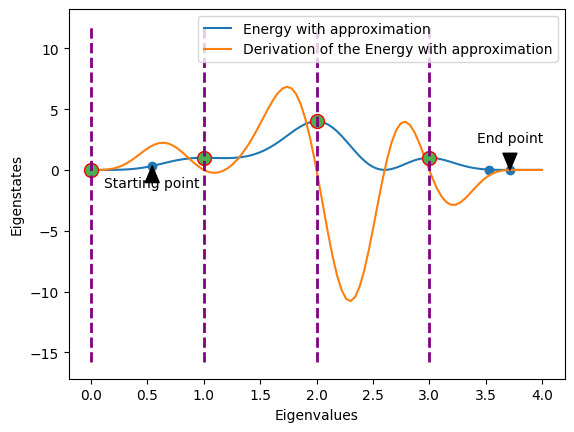

The optimal eigenstate with a variance <=  1e-08 was found.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 4 expectationvalues

active variables : 1

E=+0.34611633  angles= {a: 11.7156804486642}  samples= None
E=+1.03005783  angles= {a: 12.7256804486642}  samples= None
E=+0.02344994  angles= {a: 11.930787800026183}  samples= None
E=+0.00534331  angles= {a: 12.032927809133529}  samples= None
E=+0.00000105  angles= {a: 11.999705054796811}  samples= None
E=+0.00000062  angles= {a: 12.000001092713743}  samples= None
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


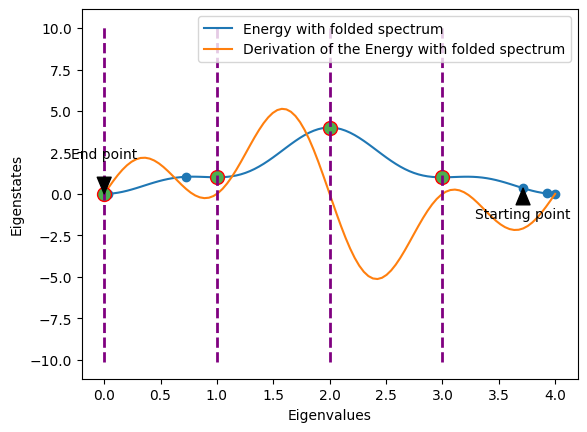

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 5 expectationvalues
gradient        : 25 expectationvalues

active variables : 1

E=+1.00000000  angles= {a: 12.000001092713743}  samples= None
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


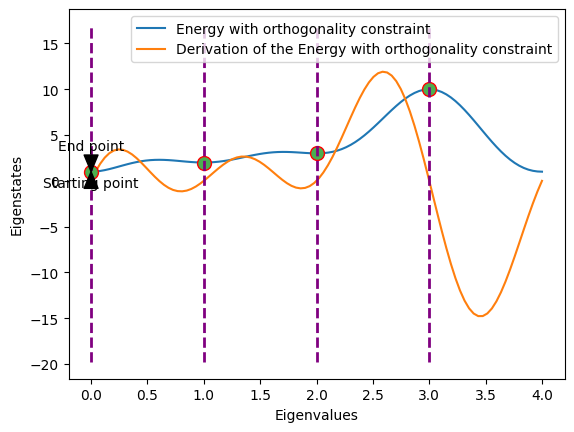

The optimal eigenstate with a variance <=  1e-08 was found.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 4 expectationvalues

active variables : 1

E=+0.00000000  angles= {a: 12.000001092713743}  samples= None
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


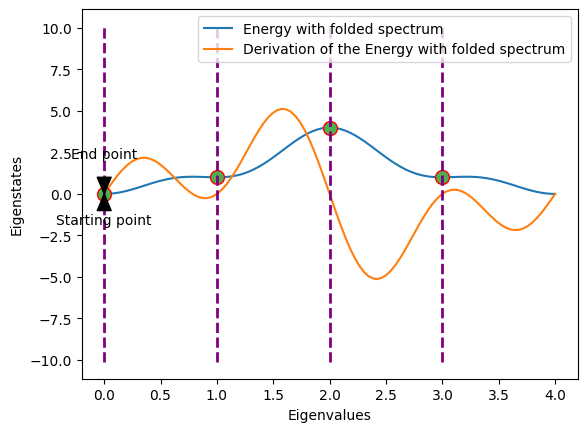

The optimal eigenstate with a variance <=  1e-08 was found.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 6 expectationvalues

active variables : 2

E=+3.47244318  angles= {a: 2.1657487184944046, b: 10.940311595374562}  samples= None
E=+0.71940029  angles= {a: 3.146988460753196, b: 10.701003074398185}  samples= None
E=+0.69521540  angles= {a: 4.034279766272513, b: 12.446706152676125}  samples= None
E=+0.05165708  angles= {a: 3.4186335812228066, b: 11.235451817503398}  samples= None
E=+0.61796165  angles= {a: 3.1705172115598135, b: 11.39415213279844}  samples= None
E=+0.00015558  angles= {a: 3.3757847234964116, b: 11.262858825112156}  samples= None
E=+0.00000061  angles= {a: 3.3735472030512828, b: 11.264626612263976}  samples= None
E=+0.00000000  angles= {a: 3.3733979

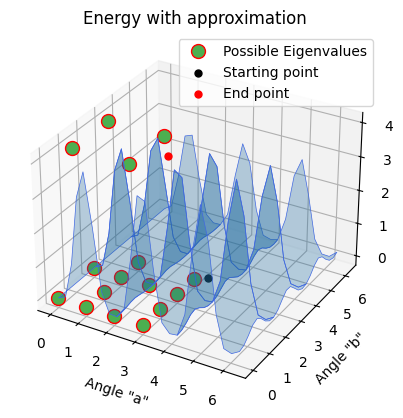

The optimal eigenstate with a variance <=  1e-08 was found.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 4 expectationvalues

active variables : 2

E=+1.71903439  angles= {a: 3.3733979674427625, b: 11.26474497474038}  samples= None
E=+1.03901412  angles= {a: 2.441698980161699, b: 11.654664193424763}  samples= None
E=+0.14722671  angles= {a: 2.192878773872805, b: 12.080677535163872}  samples= None
E=+0.02968951  angles= {a: 2.1075067630871795, b: 12.012262931066266}  samples= None
E=+0.04833570  angles= {a: 1.8681181220080905, b: 12.025266628837235}  samples= None
E=+0.00319604  angles= {a: 2.0042801442769513, b: 12.017870247047828}  samples= None
E=+0.00031830  angles= {a: 1.9983568855596832, b: 11.994380672701245}  samples= None
E=+0.00000000  angles= {a: 2.0000074

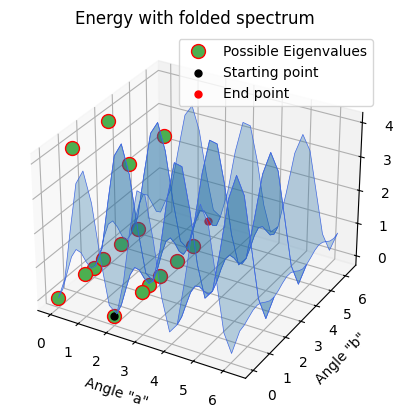

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 5 expectationvalues
gradient        : 30 expectationvalues

active variables : 2

E=+1.00000000  angles= {a: 2.000007448903694, b: 12.000001934839302}  samples= None
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


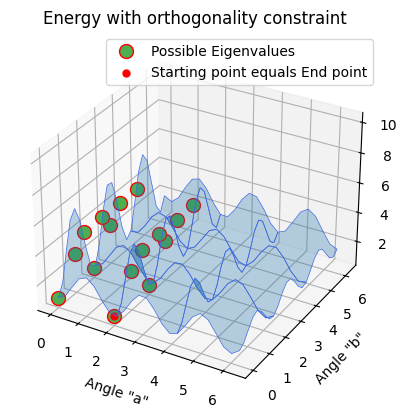

The optimal eigenstate with a variance <=  1e-08 was found.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 4 expectationvalues

active variables : 2

E=+0.00000000  angles= {a: 2.000007448903694, b: 12.000001934839302}  samples= None
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


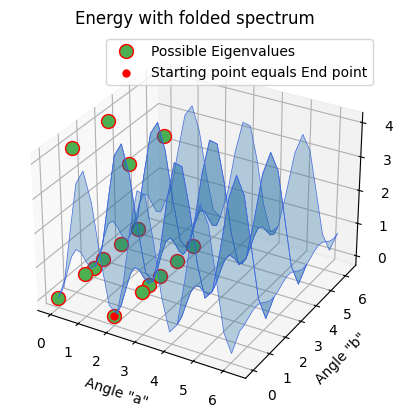

The optimal eigenstate with a variance <=  1e-08 was found.


In [59]:
#| code-fold: true
#| output: false
import tequila as tq
from tequila import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

def main(H,U, variables, variance_threshold=1.e-8, list=None):
    '''This is the main part of this programm, where the optimization strategies "folded spectrum", "approximation" and "projection"
    are being tested and plotted.
    Input:  Hamiltonian H
            curcuit U
            variables/angles as dictionary
            variance threshold (optional)
            list of ordered functions (optional) eg. ["A","P","F"] for Approximation, Projection, Folded Spectrum
    Output: 1D or 2D graphics showing the optimization process as well as the Eigenvalues/Eigenstates of H'''
    
    eigenvalues, vv = np.linalg.eigh(H.to_matrix())
    oneDimensional = True
    if (len(variables) == 2):
        oneDimensional=False
        variables = {"a": -1, "b": -0.5}
    else:
        variables = {"a": -1}

    circuit_list = []
    constant_list = []
    list_length = 4
    constant = 1
    
    for l in range(list_length):
        circuit_list.append(U.map_variables(variables))
        constant_list.append(constant)
        constant += 1
    if list==None:
        # First Projection, then Approximation, then Folded Spectrum
        E = eigensolver.expectation_value_orthogonality_constraint(H,U, circuit_list, constant_list)
        E_optimized = eigensolver.minimization(E, {"method":"BFGS"})
        eigensolver.plotting_preparation(E, E_optimized, "Energy with orthogonality constraint", eigenvalues, oneDimensional)
        if eigensolver.proof_eigenstate(H,U, variables, variance_threshold):
                print("The optimal eigenstate with a variance <= ", variance_threshold, "was found.")
        variables = E_optimized.variables
        mu = tq.simulate(tq.ExpectationValue(H=H, U=U), variables=variables)
        E_AFS = eigensolver.expectation_value_approximation(H,U, mu)
        E_AFS_optimized = eigensolver.minimization(E_AFS, {"method":"BFGS", "initial_values":variables})
        eigensolver.plotting_preparation(E_AFS, E_AFS_optimized, "Energy with approximation", eigenvalues, oneDimensional)
        if eigensolver.proof_eigenstate(H,U, variables, variance_threshold):
                print("The optimal eigenstate with a variance <= ", variance_threshold, "was found.")
        variables = E_AFS_optimized.variables
        mu = tq.simulate(tq.ExpectationValue(H=H, U=U), variables=variables)
        E_FS = eigensolver.expectation_value_folded_spectrum(H,U, mu)
        E_FS_optimized = eigensolver.minimization(E_FS, {"method":"BFGS", "initial_values":variables})
        eigensolver.plotting_preparation(E_FS, E_FS_optimized, "Energy with folded spectrum", eigenvalues, oneDimensional)
        if eigensolver.proof_eigenstate(H,U, variables, variance_threshold):
                print("The optimal eigenstate with a variance <= ", variance_threshold, "was found.")
    else:
        
        for l in list:
            if (l.isalpha()==False or len(l)!= 1):
                raise ValueError('An elemet of the list is not one letter')
            if (l == list[0]):
                mu = 1
            else:
                variables = E_optimized.variables
                mu = tq.simulate(tq.ExpectationValue(H=H, U=U), variables=variables)

            if (l == "A"):
                E = eigensolver.expectation_value_approximation(H,U, mu)
                if (l == list[0]):
                    E_optimized = eigensolver.minimization(E, {"method":"BFGS"})
                else: 
                    E_optimized = eigensolver.minimization(E, {"method":"BFGS", "initial_values":variables})
                eigensolver.plotting_preparation(E, E_optimized, "Energy with approximation", eigenvalues, oneDimensional)
                if eigensolver.proof_eigenstate(H,U, variables, variance_threshold):
                        print("The optimal eigenstate with a variance <= ", variance_threshold, "was found.")
            elif (l == "P"):
                E = eigensolver.expectation_value_orthogonality_constraint(H,U, circuit_list, constant_list)
                if (l == list[0]):
                    E_optimized = eigensolver.minimization(E, {"method":"BFGS"})
                else: 
                    E_optimized = eigensolver.minimization(E, {"method":"BFGS", "initial_values":variables})
                eigensolver.plotting_preparation(E, E_optimized, "Energy with orthogonality constraint", eigenvalues, oneDimensional)
                if eigensolver.proof_eigenstate(H,U, variables, variance_threshold):
                        print("The optimal eigenstate with a variance <= ", variance_threshold, "was found.")
            elif (l == "F"):
                E = eigensolver.expectation_value_folded_spectrum(H,U, mu)
                if (l == list[0]):
                    E_optimized = eigensolver.minimization(E, {"method":"BFGS"})
                else: 
                    E_optimized = eigensolver.minimization(E, {"method":"BFGS", "initial_values":variables})
                eigensolver.plotting_preparation(E, E_optimized, "Energy with folded spectrum", eigenvalues, oneDimensional)
                if eigensolver.proof_eigenstate(H,U, variables, variance_threshold):
                        print("The optimal eigenstate with a variance <= ", variance_threshold, "was found.")
                
            else:
                raise ValueError('An elemet of the list is not letter "A", "P" or "F"')

#----------------General functions------------
class eigensolver:
    
    def expectation_value_folded_spectrum(H,U, constant):
        return tq.ExpectationValue(H=(H-constant)**2, U=U)
    
    def expectation_value_approximation(H,U, constant):
        return (tq.ExpectationValue(H=H, U=U)-constant)**2
    
    def expectation_value_orthogonality_constraint(H,U, circuit_list, constant_list):
        E = tq.ExpectationValue(H=H, U=U)
        if (len(circuit_list) != len(constant_list)):
            raise ValueError(f"Circuit_list and constant_list have different lengths. len(circuit_list): '{len(circuit_list)}', len(constant_list): '{len(constant_list)}'")
        list_length = len(circuit_list)
        for l in range(list_length):
            if (circuit_list[l].extract_variables() == None):
                raise ValueError(f"Circuit_list contains unparametrized elements")
        U_list = []
        for i in range(0, list_length):
            U_k = U + circuit_list[i].dagger()
            P_k = 1
            for k in U_k.qubits:
                P_k*= tq.paulis.Qp(k)
            E_k = tq.ExpectationValue(H=P_k, U=U_k)
            U_list.append(constant_list[i]*E_k)
        return E + sum(U_list)

    def minimization(E, dict_of_parameters=None):
        if dict_of_parameters is None:
            dict_of_parameters = {}
        if not isinstance(dict_of_parameters, dict):
            raise TypeError(f"dict expected, got '{type(dict_of_parameters).__name__}'")
        dict_of_parameters.setdefault("method", "BFGS")
        dict_of_parameters.setdefault("initial_values", "random")
        return tq.minimize(E, **dict_of_parameters)
    
    
    def proof_eigenstate(H, U, variables, variance_threshold=1.e-4):
        V = ((tq.ExpectationValue(H=H, U=U))  **2 - tq.ExpectationValue(H=H**2, U=U)).apply(abs)
        V = tq.simulate(V, variables)
        return V <= variance_threshold
    
    def get_optimization_energies(result):
        return result.history.energies_calls

    def get_optimization_angles(result, eigenvalues):
        mod = len(eigenvalues)
        angle_dots = [{k:v % mod for k,v in x.items()} for x in result.history.angles_calls]
        angles_np = np.array([list(i.values()) for i in angle_dots])
        return angles_np
    
    def compile_E_values1D(fE, angle_range):
        return [fE({"a":v}) for v in angle_range]
    
    def compile_E_values2D(fE, angle_range):
        fE_result = []
        for v in angle_range:
            for w in angle_range:
                fE_result.append(fE({"a":v, "b":w}))
                return fE_result

    def compile_dE_values1D(fdE, angle_range):
        return [fdE({"a":v}) for v in angle_range]
    
    def compile_dE_values2D(fdE, angle_range):
        fE_result = []
        for v in angle_range:
            for w in angle_range:
                fE_result.append(fdE({"a":v, "b":w}))
                return fE_result
    
    # calculating min and max values of range of all energies (E or dE) for plotting. Returning array [y_min, y_max]
    def min_max_y_value(E, values_E, values_dE, energy_dots):
        min_max = []
        all_energy_values = []
        for v in values_E:
            all_energy_values.append(v)
        for v in values_dE:
            all_energy_values.append(v)
        y_min = energy_dots[0]
        y_max = energy_dots[0]
        for energy in all_energy_values:
            if energy < y_min:
                y_min = energy
            if energy > y_max:
                y_max = energy
        min_max.append(y_min)
        min_max.append(y_max)
        return min_max
    
    def plotting1D(aprox_name, angle_range, angles_np, values_E, values_dE, fE, energy_np, start_dot_E, end_dot_E, start_dot_angle, end_dot_angle, angles_of_eigenvalues, y_min, y_max):
        
        plt.plot(angle_range, values_E, label= str(aprox_name))
        
        plt.plot(angle_range, values_dE, label= 'Derivation of the ' + str(aprox_name))
        plt.legend([str(aprox_name), 'Derivation of the ' + str(aprox_name)])
        plt.scatter(angles_np, energy_np)
        
        for a in angles_of_eigenvalues:
            plt.plot(a, fE({"a":a}), "o",mfc = '#4CAF50',ms = 10,mec = 'r')
            plt.vlines(x=a, colors='purple', ymin=y_min-5, ymax=y_max+5, ls='--', lw=2, label='Eigenvalues')
        plt.annotate('Starting point',
        ha = 'center', va = 'bottom',
        xytext = (start_dot_angle , start_dot_E - 2),
        xy = (start_dot_angle, start_dot_E),
        arrowprops = { 'facecolor' : 'black', 'shrink' : 0.5, 'width' : 0.5, 'headwidth' : 10})
        plt.annotate('End point',
        ha = 'center', va = 'bottom',
        xytext = (end_dot_angle, end_dot_E + 2),
        xy = (end_dot_angle, end_dot_E),
        arrowprops = { 'facecolor' : 'black', 'shrink' : 0.5, 'width' : 0.5, 'headwidth' : 10})
        
        plt.xlabel("Eigenvalues")
        plt.ylabel("Eigenstates")
        plt.show()

    def plotting2D(aprox_name, start_dot_E, end_dot_E, start_dot_angle, end_dot_angle, fE, angles_of_eigenvalues):
        X=np.linspace(0.0, 2.0*np.pi,25)
        Y=X
        Z = np.zeros([25,25])
        for i,x in enumerate(X):
            for j,y in enumerate(Y):
                Z[i,j]= fE({"a":x, "b":y})
        X, Y = np.meshgrid(X, Y)
        ax = plt.figure().add_subplot(projection='3d')
        ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                        alpha=0.3, shade=True)
        
        for a in angles_of_eigenvalues:
            for b in angles_of_eigenvalues:
                if (a == angles_of_eigenvalues[0] and b == angles_of_eigenvalues[0]):
                    ax.plot(a,b, fE({"a":a, "b":b}), "o",mfc = '#4CAF50',ms = 10,mec = 'r',label="Possible Eigenvalues")
                else:
                    ax.plot(a,b, fE({"a":a, "b":b}), "o",mfc = '#4CAF50',ms = 10,mec = 'r')

        if (fE({"a":end_dot_angle[0], "b":end_dot_angle[1]}) == fE({"a":start_dot_angle[0], "b":start_dot_angle[1]})):
            ax.scatter3D(start_dot_angle[0], start_dot_angle[1],fE({"a":start_dot_angle[0], "b":start_dot_angle[1]}),color='red', s=25, label="Starting point equals End point")
        else:
            ax.scatter3D(end_dot_angle[0], end_dot_angle[1],fE({"a":end_dot_angle[0], "b":end_dot_angle[1]}),color='black', s=25, label="Starting point")
            ax.scatter3D(start_dot_angle[0], start_dot_angle[1],fE({"a":start_dot_angle[0], "b":start_dot_angle[1]}),color='red', s=25, label="End point")


        ax.set_xlabel('Angle "a"')
        ax.set_ylabel('Angle "b"')
        ax.set_zlabel('Energy')
        ax.legend()
        ax.set_title(str(aprox_name))
        plt.show()
        
    def plotting2D_chemistry(aprox_name, fE):
        X=np.linspace(0.0, 2.0*np.pi,25)
        Y=X
        Z = np.zeros([25,25])
        for i,x in enumerate(X):
            for j,y in enumerate(Y):
                Z[i,j]= fE({"a":x, "b":y})
        X, Y = np.meshgrid(X, Y)
        ax = plt.figure().add_subplot(projection='3d')
        ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                        alpha=0.3, shade=True)

        ax.set_xlabel('Angle "a"')
        ax.set_ylabel('Angle "b"')
        ax.set_zlabel('Energy')
        ax.legend()
        ax.set_title(str(aprox_name))
        plt.show()

    def plotting_preparation(E, result, aprox_name, eigenvalues, oneDimensional=True):
        angle_range = (np.linspace(0,4,100))
        angles_of_eigenvalues = eigenvalues

        fE = tq.compile(E)
        
        if oneDimensional:
            values_E = eigensolver.compile_E_values1D(fE, angle_range)
            dE = tq.grad(E, "a")
        else:
            values_E = eigensolver.compile_E_values2D(fE, angle_range)
            dE = tq.grad(E, "a", "b")
        fdE = tq.compile(dE)
        if oneDimensional:
            values_dE = eigensolver.compile_dE_values1D(fdE, angle_range)
        else:
            values_dE = eigensolver.compile_dE_values2D(fdE, angle_range)
        
        angles = eigensolver.get_optimization_angles(result, eigenvalues)
        energy_dots = eigensolver.get_optimization_energies(result)
        
        if oneDimensional:
            angles_np = []
            for xs in angles:
                for x in xs:
                    angles_np.append(x)
        else:
            angles_np = angles

        y_min = eigensolver.min_max_y_value(E, values_E, values_dE, energy_dots)[0]
        y_max = eigensolver.min_max_y_value(E, values_E, values_dE, energy_dots)[1]
        
        start_dot_E = energy_dots[0]
        end_dot_E = energy_dots[len(energy_dots)-1]
        start_dot_angle = angles_np[0]
        end_dot_angle = angles_np[len(energy_dots)-1]
        
        if oneDimensional:
            eigensolver.plotting1D(aprox_name, angle_range, angles_np, values_E, values_dE, fE, energy_dots, start_dot_E, end_dot_E, start_dot_angle, end_dot_angle, angles_of_eigenvalues, y_min, y_max)
        else:
            eigensolver.plotting2D(aprox_name, start_dot_E, end_dot_E, start_dot_angle, end_dot_angle, fE, angles_of_eigenvalues)
    

    def min_max_energy_and_angle(fE,values_E, angle_range):
        min_E = min(np.array(values_E))

        for a in angle_range:
            if (fE({"a":a}) == min_E):
                min_angle = a
                break
        max_E = max(np.array(values_E))
        for a in angle_range:
            if (fE({"a":a}) == max_E):
                max_angle = a
                break
        return min_E, max_E, min_angle, max_angle
    
# Given Hamiltonian H
H = 1.5-0.5*(tq.paulis.Z(1)-tq.paulis.Z(0)+tq.paulis.Z(0)*tq.paulis.Z(1)+tq.paulis.X(1)-tq.paulis.Z(0)*tq.paulis.X(1))

# ------------1D model--------------
a = tq.Variable("a")
variables = {"a": -1}
U = tq.gates.Ry(angle=(a)*np.pi,target=0)
U+= tq.gates.CNOT(0,1)
U+= tq.gates.Ry(angle=(a/2)*np.pi, target=1)
main(H, U, variables, variance_threshold=1.e-8, list=["A", "F", "P", "F"])

# ------------2D model--------------
a = tq.Variable("a")
b = tq.Variable("b")

variables = {"a":1.0, "b":0.7}
U = tq.gates.Ry(angle=(a)*np.pi,target=0)
U+= tq.gates.CNOT(0,1)
U+= tq.gates.Ry(angle=(b)*np.pi, target=1)
main(H, U, variables, variance_threshold=1.e-8, list=["A", "F", "P", "F"])



Let´s take a look at an exemplary 1D optimization using the approximation and subsequent folded spectrum method.

::: {#fOptimization_Approximation layout-ncol=2}

![Energy graph](Optimization_Approximation.png){#fig-surus}

![Optimization process](Optimization_Approximation_process.png){#fig-hanno}

Optimization with the Approximation method
:::

First, we start our optimization at Angle 2.15. The blue graph shows us the energy curve after applying the approximation method, the orange one the corresponding gradient.
Analyzing this, there is a decline in energy at the starting point, as the orange graph is below the 0 energy level. According to the optimization procedure, we now the curve
until we reach a local minimum (obervable along the blue dots). In our case, we reach the local minimum after 7 steps at angle 3.7.

::: {#Optimization_Folded_Spectrum layout-ncol=2}

![Energy graph](Optimization_Folded_Spectrum.png){#fig-surus}

![Optimization process](Optimization_Folded_Spectrum_process.png){#fig-hanno}

Optimization with the Folded Spectrum method
:::

This is now the starting point of the Folded Spectrum method. The graph has changed here: We can see that the gradient at the start is much lower than the one of the approximation curve at this angle.
This means that there is a point that is even lower than the one previously assumed. Therefore, we carry out the same procedure as before: we continue until we arrive at a local minimum again.
Since our optimization steps run in the right direction and in this case we always consider the angles modulo 4, we end up on the left side again. The apparent minimum at 0.0 is initially skipped in step 2
and since then we have been oscillating around the local minimum. In the last step, however, we return there and remain there. Now we have found an actual Eigenstate at angle 0.0.


::: {#2D-models layout-ncol=3}

![Approximation](Approximation_2D.png){#fig-surus}

![Projection](Projection_2D.png){#fig-hanno}

![Folded Spectrum](Folded_spectrum_2D.png){#fig-hanno}

Optimization with 2D models
:::


The same procedure was carried out in these 2D models. First with the approximation method, then the projection method and at the end the folded spectrum method.
It is not initially clear that the end point of the first method is the starting point of the second method. In fact, this is the case, only the curves have changed accordingly when the projection method has been applied.
In the second diagram it is already clear that we have reached a possible Eigenvalue. This is evident in the last excited state method, since the optimization point does not move, but stagnates at the minimum.

# Chemistry example

Since we have now familiarized ourselves with the excited state methods, we can apply them to a Hamiltonian and circuit from a real chemistry model. In the following code, this model is defined based on two angles and its
circuit is similar to the one from this [paper](https://arxiv.org/pdf/2207.12421){target="_blank"} (appendix).
We then are able to apply our known methods and plot them using 2D models.


/var/folders/pw/yjpw_zz56nv7wh1drxkrky_40000gn/T/ipykernel_84822/888881687.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


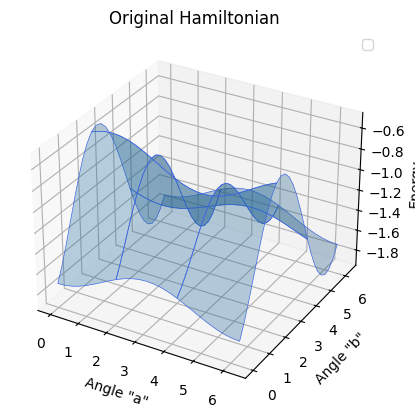

In [61]:


#| code-fold: true
#| output: false

geometry1 = "H 1.5 0.0 0.0\nH 0.0 0.0 0.0\nH 1.5 0.0 1.5\nH 0.0 0.0 1.5"
mol = tq.Molecule(geometry=geometry1, basis_set="sto-3g").use_native_orbitals()
U = tq.gates.X([0,1,2,3])
a = tq.Variable("a")#*pi
b = tq.Variable("b")#*pi
UC1 = mol.UC(0,2, a) + mol.UC(1,3, a)
UR1 = mol.UR(0,2,pi/2) + mol.UR(1,3,pi/2)
UR2 = mol.UR(0,1,pi/2) + mol.UR(2,3,pi/2)
UC2 = mol.UC(0,1, b) + mol.UC(2,3, b)

circuit_chemistry = U + UC1 + UR1.dagger() + UR2 + UC2 + UR2.dagger()  # <1>
H = mol.make_hamiltonian()

f_E= tq.compile(tq.ExpectationValue(H=H, U=circuit_chemistry))

eigensolver.plotting2D_chemistry("Original Hamiltonian", f_E)

1. This is the given circuit, which consists of two rotations and two correlations. Thus, we are particularly able to analize the correlators and study their behaviour.

<center>
![Circuit of chemistry model](chemistry_circuit.png){width=70%}
</center>

<center>
![Hamiltonian of chemistry model](original_hamiltonian_chemistry.png){width=100%}
</center>



# Conclusion

In summary, this tutorial has provided an overview of quantum Eigensolvers, a powerful tool for finding the Eigenvalues of quantum systems. We have discussed the key concepts, such as Hamiltonians,
expectation values, and excited state methods. The Tequila library was used to implement these concepts and demonstrate their application.
Building on this, we have gained some direct optimization protocols by testing different concatenations of our excited state methods, including the optimization after each of them.

Despite this, we need to take some potential errors, such as hardware errors, which can cause noise, computational errors or Ansatz errors into consideration.
Moreover the accuracy and efficiency of our Eigensolver depends highly on the choice of our given
excited state methods. Of course, there are also other possibilities of concatenations, since we have a lot of freedom in selecting the suitable parameters and order of our introduced techniques.

Overall, by addressing these challenges and leveraging future advancements, quantum Eigensolvers have the potential to become a valuable tool for solving complex problems in quantum computing and beyond.


### Further Reading
- [https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.3c01378?ref=article_openPDF
](https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.3c01378?ref=article_openPDF
){target="_blank"}
- [https://www.sciencedirect.com/science/article/pii/S0370157322003118?ref=pdf_download&fr=RR-2&rr=8d2f7feaefd39247
](https://www.sciencedirect.com/science/article/pii/S0370157322003118?ref=pdf_download&fr=RR-2&rr=8d2f7feaefd39247
){target="_blank"}
- [https://arxiv.org/pdf/1805.08138
](https://arxiv.org/pdf/1805.08138
){target="_blank"}